In [29]:
from game import MOVES_FILE
import json
from x2 import make_state, apply_move, place
import numpy as np
from numpy.typing import NDArray
from typing import Tuple
from sklearn.model_selection import train_test_split

with open(MOVES_FILE, "r") as f:
    moves = [json.loads(l) for l in f.readlines()]

with open("moves1.jsonl", "r") as f:
    moves += [json.loads(l) for l in f.readlines()]


def map_move(move):
    before = np.array(move["before"])

    mx = before.max()
    offset = 0 if mx < 12 else mx - 12 + 1

    grid = np.where(before == 0, before, before - offset)

    if (grid < 0).any() or (grid > 12).any():
        print(f"Invalid grid: {grid}, move: {move}")
        return None

    next_value = move["next_value"] - offset
    if not (1 <= next_value <= 6):
        print(f"invalid next value: {next_value}, {move}")
        return None

    return {
        "before": np.where(before == 0, before, before - offset).tolist(),
        "play": move["play"],
        "next_value": next_value,
    }


def check_move(move) -> bool:
    state = make_state(seed=0)
    state.grid = np.array(move["before"])

    mx = state.grid.max()
    state.min = 1 + (0 if mx < 12 else mx - 12)
    state.max = 6 + (0 if mx < 12 else mx - 12)

    place(state, move["play"], move["next_value"])

    return state.grid.tolist() == move["after"]


print(len(moves))

moves = [mapped for m in moves if check_move(m) and (mapped := map_move(m)) is not None]

len(moves)

505
invalid next value: 0.0, {'before': [[4.0, 13.0, 9.0, 11.0, 9.0], [2.0, 7.0, 8.0, 10.0, 7.0], [0.0, 5.0, 0.0, 0.0, 5.0], [0.0, 4.0, 0.0, 0.0, 4.0], [0.0, 8.0, 0.0, 0.0, 3.0]], 'after': [[4.0, 13.0, 9.0, 11.0, 9.0], [3.0, 7.0, 8.0, 10.0, 7.0], [0.0, 5.0, 0.0, 0.0, 5.0], [0.0, 4.0, 0.0, 0.0, 4.0], [0.0, 8.0, 0.0, 0.0, 3.0]], 'next_value': 2, 'play': 0}
invalid next value: 0.0, {'before': [[4.0, 13.0, 9.0, 11.0, 9.0], [3.0, 7.0, 8.0, 10.0, 7.0], [6.0, 5.0, 6.0, 8.0, 6.0], [0.0, 9.0, 5.0, 6.0, 4.0], [0.0, 0.0, 0.0, 8.0, 2.0]], 'after': [[4.0, 13.0, 9.0, 11.0, 9.0], [3.0, 7.0, 8.0, 10.0, 7.0], [6.0, 5.0, 6.0, 8.0, 6.0], [0.0, 9.0, 5.0, 6.0, 4.0], [0.0, 0.0, 0.0, 8.0, 3.0]], 'next_value': 2, 'play': 4}
invalid next value: 0.0, {'before': [[4.0, 13.0, 9.0, 11.0, 9.0], [3.0, 7.0, 11.0, 8.0, 7.0], [6.0, 10.0, 9.0, 5.0, 3.0], [7.0, 0.0, 4.0, 3.0, 2.0], [6.0, 0.0, 0.0, 5.0, 0.0]], 'after': [[4.0, 13.0, 9.0, 11.0, 9.0], [3.0, 7.0, 11.0, 8.0, 7.0], [6.0, 10.0, 9.0, 5.0, 6.0], [7.0, 0.0, 4.0, 0.

443

In [10]:
def stack(flat, layers=12):
  """Convert an [5, 5] representation into [5, 5, layers] with one layers for each value."""
  # representation is what each layer represents
  representation = np.arange(layers, dtype=int) + 1

  # layered is the flat board repeated layers times
  layered = np.repeat(flat[:, :,:,np.newaxis], layers, axis=-1)

  # Now set the values in the board to 1 or zero depending whether they match representation.
  # Representation is broadcast across a number of axes
  layered = np.where(layered == representation, 1, 0)

  return layered

In [11]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

def moves_to_xy(moves: list) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
    all_befores = np.array([m["before"] for m in moves]).reshape((len(moves), -1))

    y = np.array([int(m["play"]) for m in moves])

    all_next_value = np.array([m["next_value"] for m in moves]).reshape((-1, 1))

    x = np.concatenate([all_next_value, all_befores], axis=1)
    return x, y

x, y = moves_to_xy(moves)

y_oh = get_one_hot(y, 5)

x.shape, y_oh.shape

((447, 26), (447, 5))

In [12]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(26, 16),
            nn.ReLU(),
            nn.Linear(16, 5),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = NeuralNetwork().to(device)
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

x_train, x_test, y_train, y_test = train_test_split(x, y_oh, random_state=0)

X = torch.FloatTensor(x_train).to(device)
y = torch.FloatTensor(y_train).to(device)

for e in range(2500):
    pred = model(X)
    loss = loss_fn(pred, y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (e + 1) % 250 == 0:
        print(f'epoch: {e+1}')
        print(f"loss: {loss.item():>7f}")

        preds: NDArray[np.float64] = model(torch.FloatTensor(x_test).to(device)).detach().cpu().numpy()
        val = (preds.argmax(axis=1) == y_test.argmax(axis=1)).mean()
        print(f'validation acc: {val}')

Using cuda device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=26, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=5, bias=True)
  )
)
epoch: 250
loss: 1.203486
validation acc: 0.32142857142857145
epoch: 500
loss: 0.950158
validation acc: 0.3482142857142857
epoch: 750
loss: 0.757475
validation acc: 0.38392857142857145
epoch: 1000
loss: 0.613106
validation acc: 0.36607142857142855
epoch: 1250
loss: 0.496749
validation acc: 0.38392857142857145
epoch: 1500
loss: 0.403173
validation acc: 0.39285714285714285
epoch: 1750
loss: 0.331956
validation acc: 0.39285714285714285
epoch: 2000
loss: 0.284489
validation acc: 0.38392857142857145
epoch: 2250
loss: 0.249376
validation acc: 0.38392857142857145
epoch: 2500
loss: 0.220912
validation acc: 0.4017857142857143


In [21]:
import numpy as np

cpu_model = model.to("cpu")

def infer(grid: NDArray[np.float64], next_value: int) -> int:
    v = np.concatenate([[next_value], grid.ravel()]).reshape((1, -1))
    return cpu_model(torch.FloatTensor(v).to("cpu")).detach().cpu().numpy().argmax()

from typing import List
import numpy as np

rewards: List[int] = []

plays = []

for s in range(1000):
    state = make_state(seed=s)
    r = 0

    ps = []

    while True:

        move = infer(state.grid, state.next_play)
        ps.append(move)

        (state, reward, done) = apply_move(state, move)

        r += reward

        if done:
            rewards.append(r)
            plays.append(ps)
            break
            
np.mean(rewards), np.std(rewards)



(23.728, 8.80170528931752)

array([[<AxesSubplot:title={'center':'reward'}>]], dtype=object)

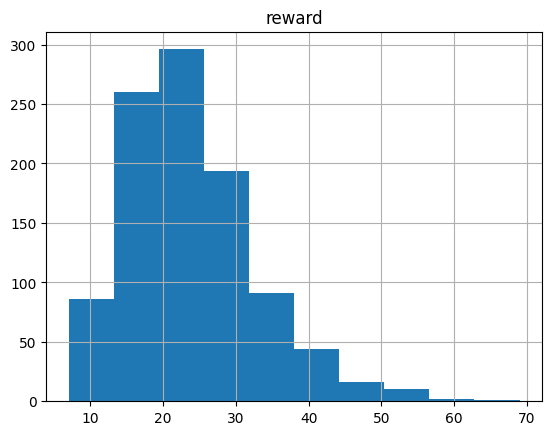

In [22]:
import pandas as pd

df = pd.DataFrame(rewards, columns=['reward'])
df.hist()

In [23]:
state = make_state(seed=2)
moves = plays[2]

r = 0

for m in moves:

    (state, reward, done) = apply_move(state, m)

    r += reward


print(r)

29
